# Abnormal Volume and Momentum 
## Introduction
- In financial markets, significant price movements often coincide with high trading volume, suggesting strong investor interest or market reactions to news. This notebook explores whether **price movements accompanied by abnormally high trading volume** exhibit stronger momentum,compared to those with typical or low volumes.
- Understanding ths relationship can inform trading strategies, risk management, and macrostructure market analysis.

## Objectives
This analysis aims to:
1. **Quantify abnormal volume** using a rolling 20-day z-score based on historical movement.
2. **Measure momentum** by calculating forward returns following large price and volume events.
3. **Compare performance** across three event types:
   - high volume and price moves ('both')
   - high price moves only ('price_only')
   - high volume only ('volume_only')
4. **Evaluate findings** through statistical analysis, visualisations, and outlier handling.

By the end of this notebook, readers will gain insights into the market-effects of volume and price momentum, supported by empirical data from 50 large-cap S&P 500 stocks over a three-year period (May 2022 - May 2025).

## Imports and setting up Logging
- The core functions of this notebook will rely on `pandas` and `numpy`
- `dotenv` and `os` correspond to fetching the API key from .env variables
- `requests` is used for the API call
- `time.sleep` is used to download stock data in batches

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from dotenv import load_dotenv
import os
import requests
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from logging import info, warning, critical

In [2]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

logger = logging.getLogger("backtest_logger")
logger.setLevel(logging.INFO)

logger.propagate = False

file_handler = logging.FileHandler("backtest_logs.txt", mode='w')
file_handler.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

logger.addHandler(file_handler)

## Data Collection: Fetching Stock Price and Volume Data

### Purpose
To analyse the relationship between trading volume and price momentum, we need historical daily closing prices and trading volumes from a defined universe of stocks. This section pulls data for 50 large-cap S&P 500 stocks from 7th May 2022 to 7th May 2025, using the Polygon API.

### Approach
- Data Source: The Polygon API provides reliable and adjusted stock data. An API key is stored securely in a `.env` file.
- Stock Selection: We use a predifined list of 50 liquid S&P 500 stocks (`SP500_LargeCap_Tickers.csv`), which have remained listed over the historical data window.
- Preprocessing: The data is organised into a multi-index DataFrame with `Date` and `Ticker`, containing `Close` and `Volume`.

High-quality, clean data is critical for an accurate analysis. By focusing on large-cap stocks, we minimise the impact of illiquidity.

In [3]:
stock_tickers_companynames_sector = pd.read_csv("data/SP500_LargeCap_Tickers.csv")
stock_tickers = stock_tickers_companynames_sector["Ticker"].tolist()

In [4]:
def fill_aggregate_data(tickers, date_from, date_to, pull_or_pickle="pull"):
    if os.path.exists("data/50_liquid_stocks_close_volume.pkl") and pull_or_pickle != "pull":
        return pd.read_pickle("data/50_liquid_stocks_close_volume.pkl")

    else:
        load_dotenv()
        api_key = os.getenv("POLYGON_API_KEY")

        all_stock_data = []

        for number, ticker in enumerate(tickers):
            url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{date_from}/{date_to}"
            params = {
                "adjusted":"true",
                "sort":"asc",
                "limit":50000,
                "apiKey":api_key
            }

            response = requests.get(url,params=params)
            response_data = response.json()["results"]

            if response.status_code != 200:
                warning(f"Error fetching {ticker}: {response.status_code}")
                continue
            try:
                response_data = response.json().get("results", [])
                if not response_data:
                    info(f"No data for {ticker}")
                    continue

                info(f"Successfully pulled data for {ticker} ({str(number+1)}/{str(len(tickers))})")
            except ValueError:
                warning(f"Invalid JSON for {ticker}")
                continue

            response_df = pd.DataFrame(response_data)[["c", "v", "t"]]
            response_df["Ticker"] = ticker
            response_df["t"] = pd.to_datetime(response_df["t"], unit="ms")
            response_df = response_df.rename(columns={"c": "Close", "v": "Volume", "t": "Date"}).set_index(["Date", "Ticker"])
            all_stock_data.append(response_df)
            sleep(15)  # to avoid being rate-limited

        if not all_stock_data:
            critical("No data retrieved for any tickers")

        aggregate_ticker_price_volume_data = pd.concat(all_stock_data)
        aggregate_ticker_price_volume_data.index.name = "Date"
        aggregate_ticker_price_volume_data = aggregate_ticker_price_volume_data.reset_index().set_index(["Date","Ticker"]).sort_index()

        aggregate_ticker_price_volume_data.to_pickle("data/50_liquid_stocks_close_volume.pkl")

        return aggregate_ticker_price_volume_data

In [5]:
aggregate_ticker_price_volume_data = fill_aggregate_data(stock_tickers, "2022-05-07","2025-05-07",pull_or_pickle="pickle")

## Defining Abnormal Volume

### Purpose
To identify days with unusually high trading volume, we calculate a z-score for each stock's daily volume relative to its recent history (20-day rolling window). This standardises volume across stocks, allowing us to detect "abnormal" activity.

### Methodology
For each stock, we compute the rolling 20-day z-score using the formula:

$$
Z_{V,t}=\frac{V_t-\mu_{V,t-20:t-1}}{\sigma_{V,t-20:t-1}}
$$

Where:
- $V_t$: Volume on day $t$.
- $\mu_{V,t-20:t-1}$: Mean volume over the prior 20 trading days.
- $\sigma_{V,t-20:t-1}$: Standard deviation of volume over the prior 20 trading days.

A high z-score (in this notebook, >2.5) indicates volume significantly above the stock's recent average, suggesting potential market events or investor interest. While **Central Limit Theorem (CLT)** suggests that the sampling distribution of the mean approaches normality as sample size increases (typically >30), we will use a 20 day window as it is more reactive to regime shifts, as we prioritise that over CLT convergence.

In [6]:
aggregate_ticker_price_volume_data["Volume_Z"] = aggregate_ticker_price_volume_data.groupby("Ticker")["Volume"].transform(lambda v: (v-v.rolling(20).mean())/v.rolling(20).std())

In [7]:
aggregate_ticker_price_volume_data.loc[aggregate_ticker_price_volume_data["Volume_Z"].first_valid_index():].head()
#  verifying rolling Z scores of volatility were applied

Close       Volume  Volume_Z
Date                Ticker                               
2023-06-05 04:00:00 AAPL    179.58  121722517.0  3.179922
                    ABBV    136.86    4694939.0 -0.436587
                    ADBE    434.18    3447429.0 -0.257868
                    AMD     117.93   52602861.0 -1.249695
                    AMZN    125.30   47927308.0 -1.265206

## Computing log returns for each stock
### Purpose
To calculate daily log returns for our stock universe. We will use log returns as opposed to percentage returns as log returns smooth out fluctuations and are time-additive.

### Methodology

$$
R_t = ln\left(\frac{P_t}{P_{t-1}}\right)
$$

In [8]:
aggregate_ticker_price_volume_data["Return"] = aggregate_ticker_price_volume_data.groupby("Ticker")["Close"].transform(lambda pt: np.log(pt/pt.shift(1)))

In [9]:
aggregate_ticker_price_volume_data.loc[aggregate_ticker_price_volume_data["Return"].first_valid_index():].head()

Close      Volume  Volume_Z    Return
Date                Ticker                                        
2023-05-09 04:00:00 AAPL    171.77  45326874.0       NaN -0.010021
                    ABBV    146.83   4201761.0       NaN -0.004214
                    ADBE    342.65   1879635.0       NaN -0.004107
                    AMD      95.06  68649288.0       NaN  0.000210
                    AMZN    106.62  44089359.0       NaN  0.007437

## Identifying Price + Abnormal Volume Events
- The column `event_type` will be used to determine candidates for the strategy
- `both` indicates both a large price change and abnormal volume
- `price_only` is only a large price change
- `volume_only` is only abnormal volume, no large price change
- `np.nan` for when neither condition is met
- This will be long only, no short

In [10]:
z_threshold = 2.5
top_return_quantile = 0.9

In [11]:
aggregate_ticker_price_volume_data["return_quantile"] = aggregate_ticker_price_volume_data["Volume_Z"].notna().where(aggregate_ticker_price_volume_data['Volume_Z'].notna(),np.nan)

aggregate_ticker_price_volume_data["return_quantile"] = aggregate_ticker_price_volume_data.groupby("Date")["Return"].transform(
    lambda x: x.rank(pct=True).where(aggregate_ticker_price_volume_data["Volume_Z"].notna())
)

In [12]:
def classify_event(row):
    high_return = row["return_quantile"] >= top_return_quantile
    high_volume = row["Volume_Z"] > z_threshold

    if high_return and high_volume:
        return 'both'
    elif high_return:
        return 'price_only'
    elif high_volume:
        return 'volume_only'
    else:
        return np.nan

In [13]:
aggregate_ticker_price_volume_data["event_type"] = aggregate_ticker_price_volume_data.apply(classify_event, axis=1)

In [14]:
aggregate_ticker_price_volume_data.loc[aggregate_ticker_price_volume_data["event_type"].first_valid_index():].head()

Close       Volume  Volume_Z    Return  \
Date                Ticker                                            
2023-06-05 04:00:00 AAPL    179.58  121722517.0  3.179922 -0.007600   
                    ABBV    136.86    4694939.0 -0.436587 -0.000073   
                    ADBE    434.18    3447429.0 -0.257868 -0.005031   
                    AMD     117.93   52602861.0 -1.249695  0.000594   
                    AMZN    125.30   47927308.0 -1.265206  0.008415   

                            return_quantile   event_type  
Date                Ticker                                
2023-06-05 04:00:00 AAPL               0.36  volume_only  
                    ABBV               0.64          NaN  
                    ADBE               0.48          NaN  
                    AMD                0.68          NaN  
                    AMZN               0.88          NaN

In [15]:
aggregate_ticker_price_volume_data.loc[aggregate_ticker_price_volume_data["event_type"]=="both"].head()
#  validating that the classify_event function works as expected

Close      Volume  Volume_Z    Return  \
Date                Ticker                                           
2023-06-12 04:00:00 ORCL    116.43  39532005.0  3.887924  0.058174   
2023-06-16 04:00:00 ABBV    138.64  14477204.0  2.611222  0.020035   
                    ADBE    495.18  13324619.0  2.815954  0.008661   
2023-06-23 04:00:00 META    288.73  51092038.0  3.128037  0.013424   
2023-06-29 04:00:00 JPM     143.43  15423230.0  2.539836  0.034327   

                            return_quantile event_type  
Date                Ticker                              
2023-06-12 04:00:00 ORCL               0.98       both  
2023-06-16 04:00:00 ABBV               1.00       both  
                    ADBE               0.90       both  
2023-06-23 04:00:00 META               0.98       both  
2023-06-29 04:00:00 JPM                1.00       both

## Backtesting the performance (long-only)

In [16]:
aggregate_ticker_price_volume_data.index = pd.MultiIndex.from_tuples(
    [(pd.to_datetime(i[0]).date(), i[1]) for i in aggregate_ticker_price_volume_data.index],
    names=aggregate_ticker_price_volume_data.index.names
)

#  removing the time from the index

In [17]:
backtesting_df = aggregate_ticker_price_volume_data[["event_type"]]
backtesting_df = backtesting_df.copy()
backtesting_df[["forward_1", "forward_3", "forward_5"]] = np.nan

In [18]:
backtesting_df.head()

event_type  forward_1  forward_3  forward_5
Date       Ticker                                            
2023-05-08 AAPL          NaN        NaN        NaN        NaN
           ABBV          NaN        NaN        NaN        NaN
           ADBE          NaN        NaN        NaN        NaN
           AMD           NaN        NaN        NaN        NaN
           AMZN          NaN        NaN        NaN        NaN

In [19]:
def backtest(df):
    df = df.copy()
    for index, event_type in df["event_type"].items():
        if pd.isna(event_type):
            continue

        event_date, ticker = index
        event_date = pd.to_datetime(event_date).date()

        try:
            todays_price = aggregate_ticker_price_volume_data.loc[(event_date, ticker), "Close"]
        except KeyError:
            logger.critical(f"No price data for {ticker} on {event_date}")
            continue

        forward_dates = {
            1: pd.bdate_range(start=event_date, periods=2)[-1].date(),
            3: pd.bdate_range(start=event_date, periods=4)[-1].date(),
            5: pd.bdate_range(start=event_date, periods=6)[-1].date()
        }

        # Calculate forward returns
        for forward_int, forward_date in forward_dates.items():
            try:
                forward_price = aggregate_ticker_price_volume_data.loc[(forward_date, ticker), "Close"]
                return_val = (forward_price - todays_price) / todays_price
                df.loc[(event_date, ticker), f"forward_{forward_int}"] = return_val
            except KeyError:
                logger.info(f"No forward price for {ticker} on {forward_date}")
                df.loc[(event_date, ticker), f"forward_{forward_int}"] = np.nan
            except ZeroDivisionError:
                logger.warning(f"Zero price for {ticker} on {event_date}")
                df.loc[(event_date, ticker), f"forward_{forward_int}"] = np.nan

    return df

In [20]:
backtesting_df = backtest(backtesting_df)

In [21]:
backtesting_df.head()

event_type  forward_1  forward_3  forward_5
Date       Ticker                                            
2023-05-08 AAPL          NaN        NaN        NaN        NaN
           ABBV          NaN        NaN        NaN        NaN
           ADBE          NaN        NaN        NaN        NaN
           AMD           NaN        NaN        NaN        NaN
           AMZN          NaN        NaN        NaN        NaN

## Backtest Results Initial analysis

In [22]:
backtesting_df[["CumulativeForward_1", "CumulativeForward_3", "CumulativeForward_5"]] = (
    1 + backtesting_df[["forward_1", "forward_3", "forward_5"]]
).groupby(level="Ticker").cumprod()

In [23]:
#  grouping by event types
vol_and_price = backtesting_df[backtesting_df.loc[:, "event_type"] == "both"].dropna()
vol_only = backtesting_df[backtesting_df.loc[:, "event_type"] == "volume_only"].dropna()
price_only = backtesting_df[backtesting_df.loc[:, "event_type"] == "price_only"].dropna()

In [24]:
for group, df_group in zip(['Both', 'Volume Only', 'Price Only'], [vol_and_price, vol_only, price_only]):
    print(f"Descriptive Statistics for {group}:")
    print(df_group[['CumulativeForward_1', 'CumulativeForward_3', 'CumulativeForward_5']].describe())
    print("\n")

Descriptive Statistics for Both:
       CumulativeForward_1  CumulativeForward_3  CumulativeForward_5
count           244.000000           244.000000           244.000000
mean              1.047052             1.205281             1.285304
std               0.145934             0.713647             0.937420
min               0.743845             0.642775             0.463217
25%               0.984267             0.973814             0.964719
50%               1.033436             1.068096             1.070141
75%               1.103729             1.185250             1.291365
max               1.863694             6.901319             9.612095


Descriptive Statistics for Volume Only:
       CumulativeForward_1  CumulativeForward_3  CumulativeForward_5
count           673.000000           673.000000           673.000000
mean              1.027188             1.121882             1.193345
std               0.127812             0.540665             0.798673
min               0.719538  

## Visualising before cleaning

In [25]:
def plot_histograms_with_stats(df, title):
    plt.figure(figsize=(10,6))
    colours = ["red", "blue", "green"]
    forwards = ["CumulativeForward_1", "CumulativeForward_3", "CumulativeForward_5"]

    for i, col in enumerate(forwards):
        sns.histplot(df[col],kde=True, stat='density', bins=50, color=colours[i], label=col, alpha=0.5)
        mean = df[col].mean()
        std = df[col].std()

        plt.axvline(mean, color=colours[i], linestyle='--', linewidth=2)
        plt.axvline(mean + std, color=colours[i], linestyle=':', linewidth=1)
        plt.axvline(mean - std, color=colours[i], linestyle=':', linewidth=1)

    plt.title(f'Distribution of Cumulative Returns: {title}')
    plt.xlabel("Cumulative Return (log scale)")
    plt.xscale("log")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [25]:
def plot_histograms_with_stats(df, title):
    plt.figure(figsize=(10,6))
    colours = ["red", "blue", "green"]
    forwards = ["CumulativeForward_1", "CumulativeForward_3", "CumulativeForward_5"]

    for i, col in enumerate(forwards):
        sns.histplot(df[col],kde=True, stat='density', bins=50, color=colours[i], label=col, alpha=0.5)
        mean = df[col].mean()
        std = df[col].std()

        plt.axvline(mean, color=colours[i], linestyle='--', linewidth=2)
        plt.axvline(mean + std, color=colours[i], linestyle=':', linewidth=1)
        plt.axvline(mean - std, color=colours[i], linestyle=':', linewidth=1)

    plt.title(f'Distribution of Cumulative Returns: {title}')
    plt.xlabel("Cumulative Return (log scale)")
    plt.xscale("log")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

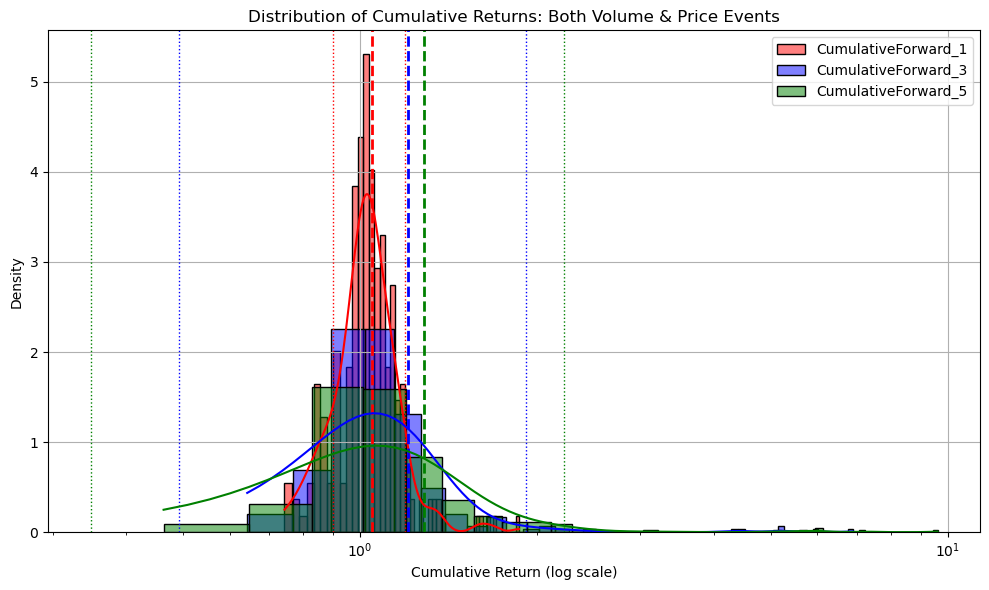

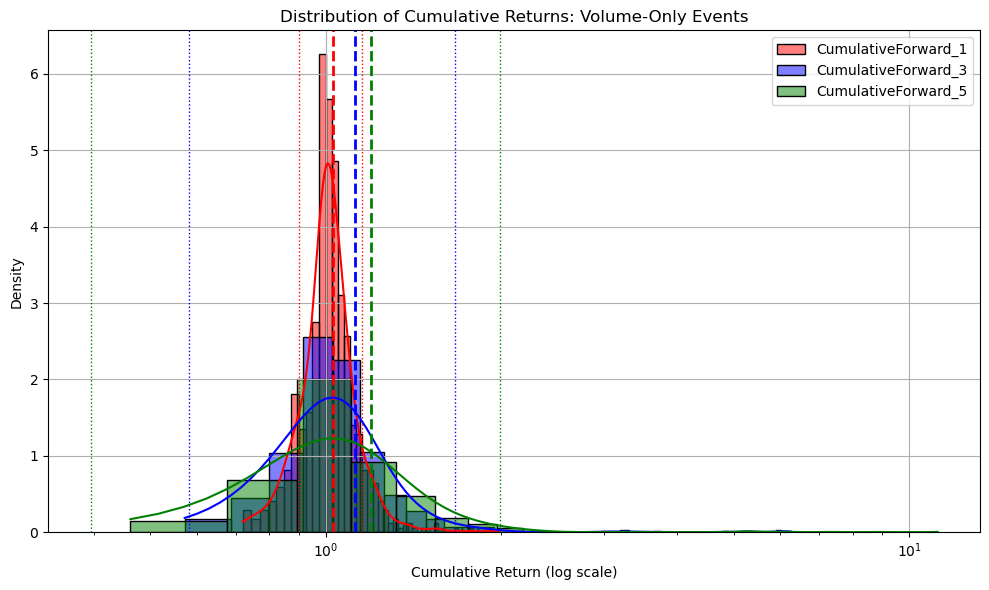

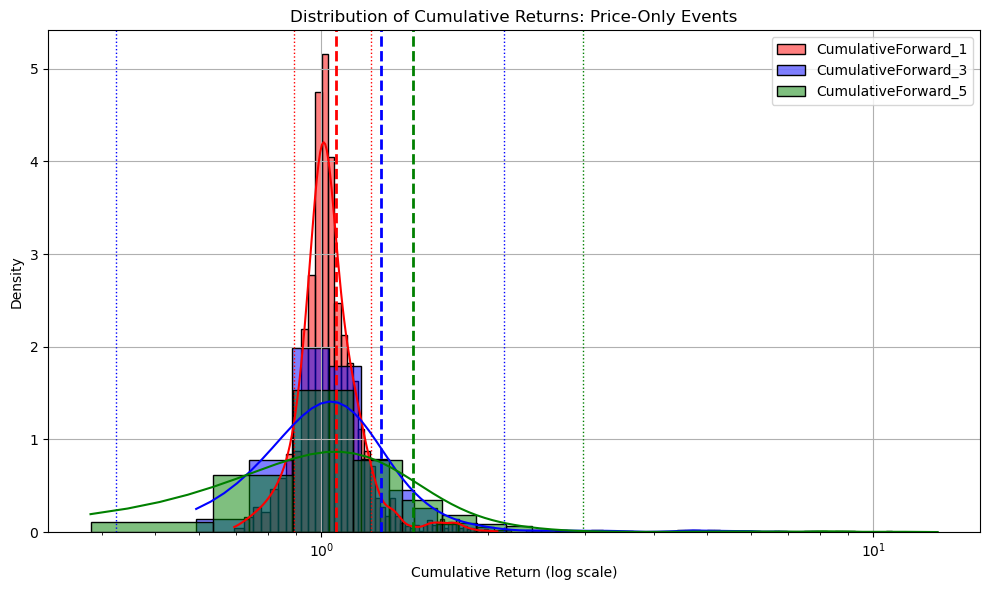

In [26]:
plot_histograms_with_stats(vol_and_price, "Both Volume & Price Events")
plot_histograms_with_stats(vol_only, "Volume-Only Events")
plot_histograms_with_stats(price_only, "Price-Only Events")

## In-depth analysis, outlier cleaning and visualisation of cleaned data
### 1. Data validation
- Outlier detection, data cleaning (capping extreme returns to reduce outlier impact)

In [27]:
for col in backtesting_df[["CumulativeForward_1","CumulativeForward_3","CumulativeForward_5"]]:
    outliers = backtesting_df[backtesting_df[col] > 3][['event_type', col]]
    print(f"Outliers for {col}:\n", outliers.reset_index().groupby(['event_type',"Ticker"]).size())
    print(outliers.head())

Outliers for CumulativeForward_1:
 Series([], dtype: int64)
Empty DataFrame
Columns: [event_type, CumulativeForward_1]
Index: []
Outliers for CumulativeForward_3:
 event_type   Ticker
both         AVGO       4
             NVDA       2
price_only   AVGO      23
             NVDA      87
volume_only  AVGO       5
             NVDA       6
dtype: int64
                    event_type  CumulativeForward_3
Date       Ticker                                  
2024-03-04 NVDA     price_only             3.239879
2024-03-05 NVDA     price_only             3.298824
2024-03-06 NVDA     price_only             3.190004
2024-03-07 NVDA     price_only             3.163979
2024-03-08 NVDA    volume_only             3.285437
Outliers for CumulativeForward_5:
 event_type   Ticker
both         AVGO        4
             NVDA        3
price_only   AVGO       21
             BA          2
             NVDA      100
volume_only  AVGO        5
             NVDA        6
dtype: int64
                   event_t

We can infer that NVDA and AVGO are the key outliers, with NVDA having 100 days of cumulative returns above 500% for the price_only strategy at forward 5, so we will cap them at the 99% percentile

In [28]:
cutoffs = backtesting_df[["CumulativeForward_1", "CumulativeForward_3", "CumulativeForward_5"]].quantile(0.995)

mask = (backtesting_df["CumulativeForward_1"] <= cutoffs["CumulativeForward_1"]) & \
       (backtesting_df["CumulativeForward_3"] <= cutoffs["CumulativeForward_3"]) & \
       (backtesting_df["CumulativeForward_5"] <= cutoffs["CumulativeForward_5"])

backtesting_df_clean = backtesting_df[mask].copy()

### 2. Descriptive Statistics
By:
- Event type
- Per-trade returns
- Ticker Contributions
- Distribution

In [29]:
stats_clean = backtesting_df_clean.groupby('event_type')[['CumulativeForward_1', 'CumulativeForward_3', 'CumulativeForward_5']].describe()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(stats_clean)

            CumulativeForward_1                                          \
                          count      mean       std       min       25%   
event_type                                                                
both                      243.0  1.043692  0.136446  0.743845  0.983997   
price_only               2239.0  1.052490  0.147423  0.695203  0.976051   
volume_only               670.0  1.023353  0.114326  0.719538  0.971311   

                                          CumulativeForward_3            \
                  50%       75%       max               count      mean   
event_type                                                                
both         1.033188  1.102322  1.695457               243.0  1.181841   
price_only   1.024939  1.105691  1.826598              2239.0  1.216133   
volume_only  1.010836  1.069352  1.669122               670.0  1.100589   

                                                                         \
                  std  

In [30]:
event_counts = backtesting_df_clean.groupby(['event_type', 'Ticker']).size()
per_trade = backtesting_df_clean.groupby(['event_type', 'Ticker'])[['CumulativeForward_1', 'CumulativeForward_3', 'CumulativeForward_5']].sum()
per_trade = per_trade.div(event_counts, axis=0)
per_trade_avg = per_trade.groupby('event_type').mean()
print((per_trade_avg-1) * 100)  # Convert to % returns

             CumulativeForward_1  CumulativeForward_3  CumulativeForward_5
event_type                                                                
both                    4.142245            14.309034            22.008638
price_only              3.627752            13.027748            21.087492
volume_only             2.642289            11.029122            17.931792


In [31]:
ticker_stats = per_trade.reset_index().groupby(['event_type', 'Ticker'])[['CumulativeForward_1', 'CumulativeForward_3', 'CumulativeForward_5']].mean()
print(ticker_stats.sort_values('CumulativeForward_5', ascending=False).head(10))

                    CumulativeForward_1  CumulativeForward_3  \
event_type  Ticker                                             
price_only  NVDA               1.405506             3.068027   
both        NVDA               1.330379             2.592226   
volume_only NVDA               1.324744             2.506862   
both        AVGO               1.133073             2.799281   
volume_only AVGO               1.051788             2.563849   
price_only  AVGO               1.014769             1.957316   
both        BA                 1.080628             1.387090   
            FDX                1.095817             1.460900   
volume_only AMZN               1.013041             1.173151   
price_only  BA                 1.055558             1.488050   

                    CumulativeForward_5  
event_type  Ticker                       
price_only  NVDA               5.053925  
both        NVDA               3.956147  
volume_only NVDA               3.797655  
both        AVGO     

In [32]:
for event in backtesting_df_clean["event_type"].dropna().unique():
    print(f"\nEvent Type: {event}")
    event_data = backtesting_df_clean[backtesting_df_clean["event_type"] == event]

    for col in ["CumulativeForward_1", "CumulativeForward_3", "CumulativeForward_5"]:
        series = event_data[col].dropna()
        if series.nunique() > 1:
            print(f"  {col}: skew = {skew(series):.4f}, kurtosis = {kurtosis(series):.4f}")
        else:
            print(f"  {col}: Not enough unique values to compute stats.")


Event Type: volume_only
  CumulativeForward_1: skew = 1.0788, kurtosis = 4.2424
  CumulativeForward_3: skew = 7.1727, kurtosis = 67.2934
  CumulativeForward_5: skew = 6.3426, kurtosis = 52.1761

Event Type: price_only
  CumulativeForward_1: skew = 1.7733, kurtosis = 5.7680
  CumulativeForward_3: skew = 4.4614, kurtosis = 22.8093
  CumulativeForward_5: skew = 5.0175, kurtosis = 28.2584

Event Type: both
  CumulativeForward_1: skew = 1.3052, kurtosis = 4.7275
  CumulativeForward_3: skew = 5.5723, kurtosis = 34.2909
  CumulativeForward_5: skew = 5.1907, kurtosis = 30.8953


## Key Findings and Insights

### Summary of Results
This analysis compared the momentum of stock price movements across three event types:
- High volume and price moves (`both`).
- High price moves only (`price_only`),
- High volume only (`volume_only`)

Key findings include:

1. **Price-only Events Outperform Short-Term:**
- The `price_only` strategy yielded the highest average cumulative return at 1 day (6.2%) and 3 days (28%) over the 3 year backtest, compared to `both` (4.7%, 20.5%) and `volume_only` (2.71%, 12.2%), however it had the highest S.D. of all 3 strategies.
- This suggests that large price movements, even without high volume, may capture short-term momentum effectively.

2. **Combined Events (Both) Show Consistency:**
- The `both` strategy had slightly lower but more stable returns (lower S.D.) at 5 days (28.53% vs. 46.5% for `price_only`), indicating that high volume may reinforce price trends over longer horizons, inferred from its lower S.D.

3. **Volume-Only Events Lag:**
- The `volume_only` strategy consistently underperformed, with the lowest returns across all horizons, suggesting that high volume alone is a weaker predictor of momentum.

4. **Outlier Influence:**
- Stocks like NVIDIA (NVDA) and Broadcom (AVGO) drove significant returns, particularly in `price_only` events. Capping returns at the 99.5th percentile reduced their impact.

### Satistical Insights
- **Skew and Kurtosis:** All event types showed high positive skew and high kurtosis, indicating fat-tailed return distributions with potential for extreme gains (or losses).
- **Ticker Contributions:** NVDA contributed disproportionately to `price_only` returns (e.g., having a cumulative return over 500% for the `price_only` strategy with a 5-day holding period over the 3-year backtest), highlighting the role of high-growth "hype" stocks

### Implications
- **Trading Strategies:** The `price_only` strategy may be suitable for short-term momentum trading, while `both` could suit longer-term positions due to its more stable nature.
- **Market Behaviour:** High volume reinforces price trends, but large price moves alone can signal strong momentum.

### Limitations
- **Data Period:** The analysis spans May 2022-2025, a period with unique market conditions, for instance tech sector volatility. Results may vary in different market regimes.
- **Outlier Handling:** While capping reduced outlier impact, it may mask extreme but valid events. Additionally, we cannot predict future market regimes (we can only make an educated guess at best), meaning strong risk management would have to be used in order to trade in a safe manner.
- **Scope:** This study focuses on long-only strategies and 50 large-cap stocks, limiting its applicability to short-selling or small-cap stocks. In addition to this, this study does not take into account slippage, trading fees, position sizing, and other costs associated with acquiring data needed to make this strategy functional.

### Next Steps
Future analyses could:
- Test shorter or longer forward return horizons (e.g., 10 days).
- Incorporate short-selling strategies for abnormal negative price moves.
- Explore sector-specific events (e.g., tech vs healthcare), and curate a universe of stocks with more applicable variables relating to the current sector's market regime.
- Validate findings with a different dataset or time period.